Data Collection Time Stats:

- For transcript 5686, 1959 tokens needs to be tagged
- 1701 Unique Tokens received tags with WordNet sense(s).
- 5693 Tags received.

```
Participant   Time Taken	# Tokens Received Tags In WordNet			Speed (tokens/min)
62            11.5 h 		1653										2.3957

60            12.5 h 		1665										2.2200

61            10   h		1648										2.7467
```

AVG Speed (tokens/min/person): 2.454

In Collection 3 (Eng-NA), there are in total 3,748,763 tokens that requires tagging


In [121]:
def getEstimatesForTokenCount(tokenCount, tokensPerMinute, numTagsPerToken):
    print('Processing '+str(tokenCount)+' at the rate of '+str(tokensPerMinute)+' tokens '+ 
    'per minute, and assuming '+str(numTagsPerToken)+' redundant judgments will take:')
    num_hours = ((tokenCount / tokensPerMinute) / 60)*numTagsPerToken
    print(str(round(num_hours)) + ' hours')
    print('~ or about ~')
    print(str(round(num_hours / 2000))+' person-years')
    print('~ assuming US Federal minimum wage ~')
    print('$'+str(round(7.25 * num_hours)))

In [125]:
# All Eng-NA
getEstimatesForTokenCount(tokenCount=3748763, tokensPerMinute=2.454, numTagsPerToken=3)

Processing 3748763 at the rate of 2.454 tokens per minute, and assuming 3 redundant judgments will take:
76381 hours
~ or about ~
38 person-years
~ assuming US Federal minimum wage ~
$553760


In [126]:
# Manchester
getEstimatesForTokenCount(tokenCount=678296, tokensPerMinute=2.454, numTagsPerToken=3)

Processing 678296 at the rate of 2.454 tokens per minute, and assuming 3 redundant judgments will take:
13820 hours
~ or about ~
7 person-years
~ assuming US Federal minimum wage ~
$100197


With optimizations to the UI, we might be able to double the number of tokens tagged per minute

# Data Preview

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


tags_df = pd.read_csv("tags.csv", names=["gloss_with_replacement",
                                         "participant_id",
                                         "sense_offset",
                                         "part_of_speech",
                                         "token_id"],
                      header=None
                      )

tags_df.sense_offset = tags_df.sense_offset.fillna(0)
tags_df.sense_offset = tags_df.sense_offset.astype(int)

print(tags_df[:10])


  gloss_with_replacement  participant_id  sense_offset part_of_speech  \
0                   like              55       1825962              v   
1                  think              55        628491              v   
2                  think              55        631737              v   
3                  think              55        689344              v   
4                  think              55        689809              v   
5                 reason              55       5819149              n   
6                     do              55       2561995              v   
7                pretend              55       2275799              v   
8                 school              55       4146050              n   
9                 school              55       8276720              n   

   token_id  
0   4013210  
1   5124933  
2   5124933  
3   5124933  
4   5124933  
5   5125176  
6   5125581  
7   4287775  
8   4287803  
9   4287803  


## Basic Stats

In [4]:
grouped_df = tags_df.groupby(["participant_id", "token_id"]).size().groupby(level=0)

for key, item in grouped_df:
    print("participant_id", "\t\t# of tokens tagged")
    print(key, "\t\t\t", grouped_df.get_group(key).size, "\n\n")


participant_id 		# of tokens tagged
55 			 25 


participant_id 		# of tokens tagged
59 			 5 


participant_id 		# of tokens tagged
60 			 1665 


participant_id 		# of tokens tagged
61 			 1648 


participant_id 		# of tokens tagged
62 			 1653 




According to the above data, choosing participant 60, 61, 62 as targets.

# Preparation

In [5]:
participant_ids = [60, 61, 62]

token_id_set = set(tags_df.token_id.unique())
print("# of Tokens: ", len(token_id_set))

from nltk.corpus import wordnet as wn

pos_map = {
    'v': wn.VERB,
    'n': wn.NOUN,
    'adj': wn.ADJ,
    'adv': wn.ADV
}

from collections import defaultdict, Counter

tags_count_smooth = defaultdict(Counter)

# of Tokens:  1701


### Random Data Generation

In [6]:
import random

grouped_token = tags_df.groupby(["token_id", "participant_id"]).size().reset_index(name="size")

raw_tags_df = tags_df.loc[tags_df.participant_id.isin(participant_ids), ["token_id", "participant_id", "sense_offset"]]
random_tags_df = pd.DataFrame()

for token_id in token_id_set:
    token_gloss = tags_df.loc[tags_df.token_id == token_id, "gloss_with_replacement"].iloc[0]
    token_pos = tags_df.loc[tags_df.token_id == token_id, "part_of_speech"].iloc[0]
    senses = list(map(lambda synset_obj: synset_obj.offset(), wn.synsets(token_gloss, pos_map[token_pos])))
    tags_count_smooth[token_id].update(senses)

    for participant_id in participant_ids:
        num_selected_s = grouped_token.loc[
            (grouped_token.token_id==token_id) & (grouped_token.participant_id==participant_id), "size"
        ]
        num_selected = 0 if num_selected_s.empty else num_selected_s.iloc[0]
        
        random.shuffle(senses)
        random_selection = senses[:num_selected]
        for selection in random_selection:
            random_tags_df = random_tags_df.append(
                {"token_id": token_id,
                 "participant_id": participant_id, 
                 "sense_offset": selection}, ignore_index=True).astype(int)

In [7]:
print(len(random_tags_df), len(raw_tags_df))


5691 5693


# Entropy over each token:


### Preprocessing Counts:

In [8]:
from copy import deepcopy

tags_count = defaultdict(Counter)

random_tags_count = defaultdict(Counter)
random_tags_count_smooth = deepcopy(tags_count_smooth)

for token_id in token_id_set:
    chosen_senses = list(raw_tags_df[raw_tags_df.token_id == token_id].sense_offset)
    random_chosen_senses = list(random_tags_df[random_tags_df.token_id == token_id].sense_offset)
    
    tags_count[token_id].update(chosen_senses)
    tags_count_smooth[token_id].update(chosen_senses)
    
    random_tags_count[token_id].update(random_chosen_senses)
    random_tags_count_smooth[token_id].update(random_chosen_senses)
    

from itertools import islice


def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print(take(10, tags_count.items()))
print(take(10, tags_count_smooth.items()))

print(take(10, random_tags_count.items()))


[(5136384, Counter({1170052: 3})), (5099522, Counter({631737: 3, 628491: 2, 739340: 1, 1637166: 1})), (5120004, Counter({0: 3})), (5200556, Counter({1848718: 2, 0: 1})), (5132300, Counter({4335209: 3, 4334599: 3})), (5193741, Counter({7745466: 3})), (5184914, Counter({0: 3})), (5103634, Counter({0: 2, 96921: 1})), (5173272, Counter({0: 3})), (5144602, Counter({7828807: 3, 5716462: 1}))]
[(5136384, Counter({1170052: 4, 1172275: 1, 1175467: 1, 737005: 1, 1171183: 1})), (5099522, Counter({631737: 4, 628491: 3, 739340: 2, 1637166: 2, 689344: 1, 607780: 1, 608808: 1, 629738: 1, 723056: 1, 689809: 1, 708538: 1, 739082: 1, 561887: 1})), (5120004, Counter({0: 3, 7275489: 1, 4693900: 1, 14286549: 1, 7392982: 1})), (5200556, Counter({1848718: 3, 434374: 1, 1318849: 1, 676267: 1, 2721284: 1, 1192773: 1, 2617798: 1, 1076615: 1, 539110: 1, 2176268: 1, 149583: 1, 2618001: 1, 2737876: 1, 2729819: 1, 0: 1, 2618149: 1, 1192992: 1, 1525666: 1, 2700772: 1, 1864230: 1, 2653862: 1, 2700455: 1, 1835496: 1, 

### Entropy Computation (`scipy.stats.entropy`):

In [10]:

from scipy.stats import entropy


def compute_entropy(tags):
    token_entropy = dict()
    for token_id, tag_count in tags.items():
        token_entropy[token_id] = entropy(list(tag_count.values()))
    return token_entropy


token_entropy = compute_entropy(tags_count)
token_entropy_smooth = compute_entropy(tags_count_smooth)

random_entropy = compute_entropy(random_tags_count)
random_entropy_smooth = compute_entropy(random_tags_count_smooth)

print("Token Entropy: ", take(10, token_entropy.items()), "\n")
print("Token Entropy Smooth: ", take(10, token_entropy_smooth.items()), "\n")

print("Random Entropy: ", take(10, random_entropy.items()), "\n"
      )


Token Entropy:  [(5136384, 0.0), (5099522, 1.277034259466139), (5120004, 0.0), (5143212, 0.0), (5132300, 0.6931471805599453), (5124109, 0.0), (5156882, 0.5623351446188083), (5109081, 0.6365141682948128), (5173272, 0.0), (5144602, 0.5623351446188083)] 

Token Entropy Smooth:  [(5136384, 1.3862943611198906), (5099522, 2.4150521219178076), (5120004, 1.4750763110546947), (5143212, 2.4260151319598084), (5132300, 1.3896811919839047), (5124109, 0.0), (5156882, 2.425479708432719), (5109081, 1.8891591637540217), (5173272, 1.9730014063936128), (5144602, 0.9556998911125343)] 

Random Entropy:  [(5136384, 0.6365141682948128), (5099522, 1.7478680974667573), (5120004, 0.6365141682948128), (5143212, 1.0986122886681096), (5132300, 1.0114042647073516), (5124109, 0.0), (5156882, 1.0397207708399179), (5109081, 0.6365141682948128), (5173272, 1.0986122886681096), (5144602, 1.0397207708399179)] 



### Plots:

In [12]:
columns=["token_id", "entropy"]

token_entropy_df = pd.DataFrame(token_entropy.items(), columns=columns)
token_entropy_smooth_df = pd.DataFrame(token_entropy_smooth.items(), columns=columns)

random_entropy_df = pd.DataFrame(random_entropy.items(), columns=columns)
random_entropy_smooth_df = pd.DataFrame(random_entropy_smooth.items(), columns=columns)

print(token_entropy_df[:10])
print(random_entropy_smooth_df[:10])


   token_id   entropy
0   5136384  0.000000
1   5099522  1.277034
2   5120004  0.000000
3   5143212  0.000000
4   5132300  0.693147
5   5124109  0.000000
6   5156882  0.562335
7   5109081  0.636514
8   5173272  0.000000
9   5144602  0.562335
   token_id   entropy
0   5136384  1.494175
1   5099522  2.484367
2   5120004  1.277034
3   5200556  3.370481
4   5132300  1.468140
5   5124109  0.000000
6   5156882  2.476247
7   5109081  1.676988
8   5173272  1.886697
9   5144602  1.078992


# of Tokens:  1701


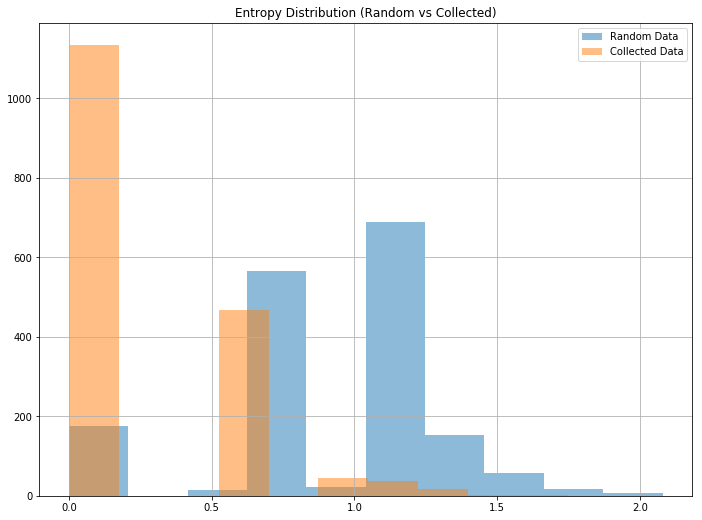

In [13]:
from matplotlib import pyplot

entropy_dist_df = token_entropy_df["entropy"]
random_entropy_dist_df = random_entropy_df["entropy"]
print("# of Tokens: ", len(token_entropy_df))


a4_dims = (11.7, 8.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set_title("Entropy Distribution (Random vs Collected)")
random_entropy_dist_df.hist(alpha=0.5, label="Random Data", ax=ax)
entropy_dist_df.hist(alpha=0.5, label="Collected Data", ax=ax)
ax.legend()


In [14]:

tokens_df = tags_df[["token_id", "gloss_with_replacement", "part_of_speech"]].drop_duplicates()

merged_token_entropy = pd.merge(token_entropy_df, tokens_df, on="token_id", how="left")

print(merged_token_entropy.sort_values(by="entropy", ascending=False)[:100])

merged_token_entropy.to_csv("tags_entropy.csv", index=False)


      token_id   entropy gloss_with_replacement part_of_speech
535    5125422  1.747868                 better            adv
1401   5139796  1.695743                   make              v
762    5097289  1.549826                   know              v
48     5107832  1.475076                   make              v
805    5181766  1.386294                   make              v
263    5108402  1.386294                    see              v
1146   5176021  1.351784                  world              n
1469   5175893  1.351784                  world              n
680    5101206  1.332179                   have              v
285    5133025  1.332179                   come              v
984    5138793  1.332179                  night              n
1030   5138903  1.329661                  night              n
1082   5141602  1.320888                   make              v
1514   5090917  1.313834                    end              n
1430   5139868  1.277034                   make        


# KL Divergence



### KL Divergence Computation (`scipy.stats.entropy`):

In [16]:
import itertools


def generate_kl(input_tags_df):
    kl_df = pd.DataFrame()
    
    for token_id in token_id_set:
        token_gloss = tags_df.loc[tags_df.token_id == token_id, "gloss_with_replacement"].iloc[0]
        token_pos = tags_df.loc[tags_df.token_id == token_id, "part_of_speech"].iloc[0]
        senses = list(map(lambda synset_obj: synset_obj.offset(), wn.synsets(token_gloss, pos_map[token_pos])))
        
        def get_prob_distribution(tagger):
            chosen_senses_from_tagger = set(input_tags_df.loc[
                (input_tags_df.token_id == token_id) & (input_tags_df.participant_id == tagger), "sense_offset"
            ])
            if not chosen_senses_from_tagger:
                chosen_senses_from_tagger = set(senses)
    
            total_tags_by_tagger = len(chosen_senses_from_tagger)
            return [(2 if sense_i in chosen_senses_from_tagger else 1) / (total_tags_by_tagger + 1) for sense_i in senses ]
        
        kl_sum = 0.0
        
        for tagger_a, tagger_b in itertools.permutations(participant_ids, 2):
            sense_prob_dist_from_a = get_prob_distribution(tagger_a)
            sense_prob_dist_from_b = get_prob_distribution(tagger_b)
            
            kl_sum += entropy(pk=sense_prob_dist_from_a, qk=sense_prob_dist_from_b)
            
        kl_df = kl_df.append({
            "token_id": token_id,
            "avg_kl": len(participant_ids) * (len(participant_ids) - 1) * kl_sum
        }, ignore_index=True)
    
    kl_df.token_id = kl_df.token_id.astype(int)
    return kl_df


tags_kl_df = generate_kl(raw_tags_df)
random_tags_kl_df = generate_kl(random_tags_df)


### Result Showcase:

In [17]:
print(tags_kl_df[:10])
print(random_tags_kl_df[:10])

merged_token_kl = pd.merge(tags_kl_df, tokens_df, on="token_id", how="left")

print(merged_token_kl.sort_values(by="avg_kl", ascending=False)[:100])

merged_token_kl.to_csv("tags_avg_kl.csv", index=False)


     avg_kl  token_id
0  0.000000   5136384
1  0.000000   5120004
2  0.000000   5193741
3  1.109035   5103634
4  1.247665   5144602
5  0.000000   5193754
6  0.000000   5136418
7  0.000000   5160995
8  0.000000   5095460
9  0.000000   5111857
     avg_kl  token_id
0  2.772589   5136384
1  3.327106   5120004
2  4.158883   5193741
3  2.772589   5103634
4  5.198604   5144602
5  6.238325   5193754
6  5.545177   5136418
7  3.327106   5160995
8  2.772589   5095460
9  2.495330   5111857
        avg_kl  token_id gloss_with_replacement part_of_speech
1471  5.198604   5094221                  there            adv
50    4.297513   5120285                   here            adv
62    4.297513   5120346                   here            adv
81    4.297513   5120425                   here            adv
1670  4.297513   5136220               fountain              n
918   4.158883   5108303                   here            adv
1199  4.158883   5199627                  there            adv
1003  4.1588

### Plot:

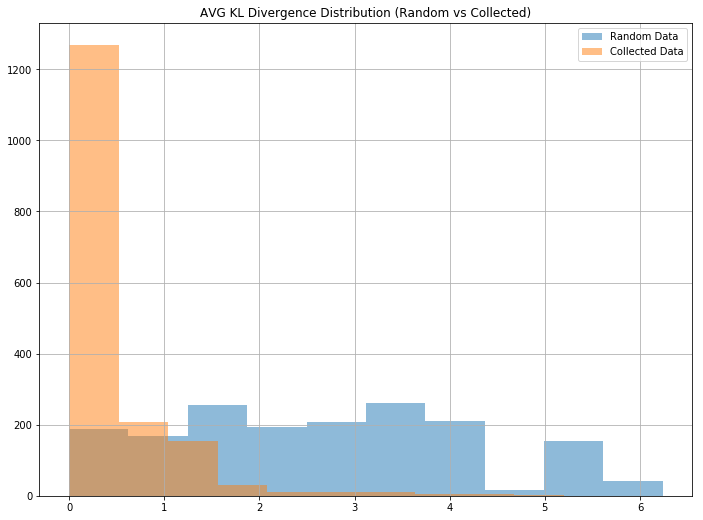

In [18]:
kl_dist_df = tags_kl_df["avg_kl"]
random_kl_dist_df = random_tags_kl_df["avg_kl"]

fig1, ax1 = pyplot.subplots(figsize=a4_dims)
ax1.set_title("AVG KL Divergence Distribution (Random vs Collected)")
random_kl_dist_df.hist(alpha=0.5, label="Random Data", ax=ax1)
kl_dist_df.hist(alpha=0.5, label="Collected Data", ax=ax1)
ax1.legend()


In [34]:
# Which individual tokens have the highest symmetrized KL divergence?
highest_kl_tokens = tags_kl_df.sort_values(by=["avg_kl"], ascending=False).head(5)
print(highest_kl_tokens)

        avg_kl  token_id
1471  5.198604   5094221
50    4.297513   5120285
62    4.297513   5120346
81    4.297513   5120425
1670  4.297513   5136220


In [37]:
# use the token_id to get back the original tags
tags_df.loc[tags_df.token_id.isin(highest_kl_tokens.token_id),].sort_values(by=['token_id', 'participant_id'])

,gloss_with_replacement,participant_id,sense_offset,part_of_speech,token_id
81,there,60,109461,adv,5094221
290,there,61,109151,adv,5094221
291,there,61,109328,adv,5094221
831,there,62,109151,adv,5094221
653,here,60,108479,adv,5120285
654,here,60,108647,adv,5120285
1060,here,61,108773,adv,5120285
1913,here,62,108479,adv,5120285
655,here,60,108479,adv,5120346
656,here,60,108647,adv,5120346


In [ ]:
# 5094221: 61 and 62 choose 109151;  60 chooses a different one; 61 also chooses 109328
# 5120285: 60 and 62 choose 108479; 60 chooses also  chooses 108647; 61 chooses a different one  108773
# these are all 4 tags, 1 agreeement between the participants. The computed KL divergence
# is sensitive toe the total number of categories

# Measures of Inter-Rater Agreement

Take the subset of tokens with one label per person, and compute Fleiss's Kappa. What proportion of the tokens is this?

In [100]:
tags_per_participant = tags_df.groupby(['token_id','participant_id'])['sense_offset'].agg(lambda x: len(np.unique(x))).reset_index()
tags_per_participant.head(5)
one_tag_per_participant = tags_per_participant.loc[tags_per_participant.sense_offset == 1]
one_tag_per_participant.head(5)
num_onetags_per_token = one_tag_per_particiapnt.groupby(['token_id']).sense_offset.agg(np.sum).reset_index()
float(num_onetags_per_token.loc[num_onetags_per_token.sense_offset ==3].shape[0]) / len(np.unique(tags_df.token_id))

0.7125220458553791

In [101]:
float(num_onetags_per_token.shape[0])

1628.0

In [102]:
num_onetags_per_token.sense_offset.value_counts()

3    1212
2     273
1     139
5       3
4       1
Name: sense_offset, dtype: int64

In [103]:
# so for these 1212 / 70% of tokens we can compute Fleiss's Kappa

In [104]:
tags_df_3tags = tags_df.loc[tags_df.token_id.isin(num_onetags_per_token.loc[
    num_onetags_per_token.sense_offset == 3].token_id)]

In [97]:
# populate the matrix of the format necessary to compute Fleiss's Kappa
token_ids = np.unique(tags_df_3tags.token_id)
sense_ids = np.unique(tags_df_3tags.sense_offset)

N = len(token_ids)
print(N)
k = len(sense_ids)
print(k)

tag_matrix = np.zeros([N,k])

for record in tags_df_3tags.to_dict('records'):
    tag_matrix[np.argwhere(token_ids == record['token_id']), 
        np.argwhere(sense_ids == record['sense_offset'])] +=1 

1212
353


In [105]:
def fleiss_kappa(M):
  '''
  See `Fleiss' Kappa <https://en.wikipedia.org/wiki/Fleiss%27_kappa>`_.
  :param M: a matrix of shape (:attr:`N`, :attr:`k`) where `N` is the number of subjects
  :and `k` is the number of categories into which assignments are made. 
  :`M[i, j]` represent the number of raters who assigned the `i`th subject to the `j`th category.
  :type M: numpy matrix
  '''
  N, k = M.shape  # N is # of items, k is # of categories
  n_annotators = float(np.sum(M[0, :]))  # # of annotators

  p = np.sum(M, axis=0) / (N * n_annotators)
  P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
  Pbar = np.sum(P) / N
  PbarE = np.sum(p * p)

  kappa = (Pbar - PbarE) / (1 - PbarE)

  return kappa

In [106]:
fleiss_kappa(tag_matrix)

0.9059610129109003